In [1]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.gridspec as gridspec

%matplotlib inline

# EDA

In [2]:
my_data=pd.read_csv("creditcard.csv")
my_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


V1, V2,... V28 have been transformed with PCA

might be originally credit card number, expiry date, CVV, cardholder name, transaction location, transaction date-time, etc.

In [3]:
my_data.isnull().sum().max() 

0

没有缺失值

Text(0, 0.5, 'count')

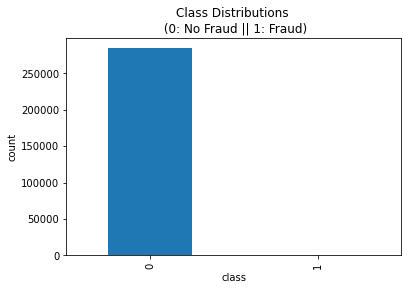

In [4]:
count_class=pd.value_counts(my_data["Class"],sort=True).sort_index()
count_class.plot(kind="bar")
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)')
plt.xlabel("class")
plt.ylabel("count")

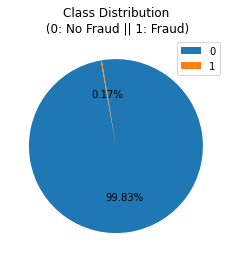

In [5]:
explode = [0,0.001]
plt.pie(my_data['Class'].value_counts(), 
        explode=explode,autopct='%1.2f%%', startangle=100)
plt.legend(labels=['0','1'])
plt.title('Class Distribution\n (0: No Fraud || 1: Fraud)');


In [6]:
print(my_data['Class'].value_counts())
print()
print('No Frauds', 
      round(my_data['Class'].value_counts()[0]/len(my_data) 
                         * 100,2), '% of the dataset')
print('Frauds', 
      round(my_data['Class'].value_counts()[1]/len(my_data) 
                      * 100,2), '% of the dataset')


0    284315
1       492
Name: Class, dtype: int64

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

If we use this dataframe as the base for our predictive models and analysis, our algorithms will probably overfit since it
will "assume" that most transactions are not a fraud.

In [7]:
#描述性统计数据
my_data[['Time','Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


-On an average, credit card transaction is happening at every 94813.86 seconds. 

-Average transaction amount is 88.35 with a standard deviation of 250, with a minimum amount of 0.0 and the maximum amount 25,691.16. By seeing the 75% and the maximum amount, it looks like the feature 'Amount' is highly positively skewed. We will check the distribution graph of the amount to get more clarity.

## distribution


/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


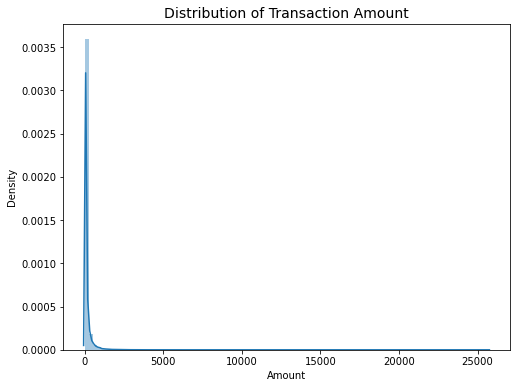

In [8]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Transaction Amount', fontsize=14)
sns.distplot(my_data['Amount'], bins=100)
plt.show()

Most the transaction amount falls between 0 and about 3000 and we have some outliers for really big amount transactions

/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


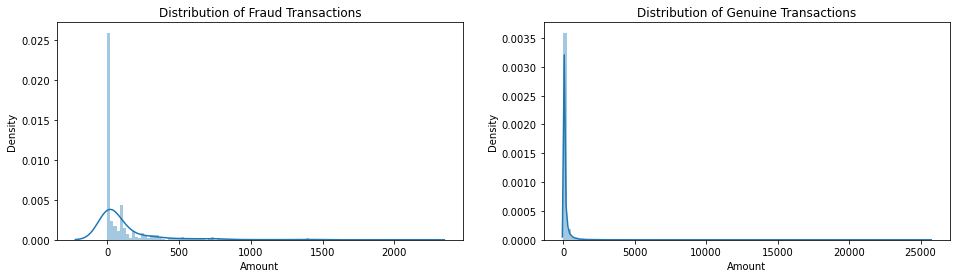

In [9]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
sns.distplot(my_data[my_data['Class'] == 1]['Amount'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(my_data[my_data['Class'] == 0]['Amount'], bins=100, ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

plt.show()

This graph shows that most of the fraud transaction amount is less than 500 dollars. This also shows that the fraud transaction is very high for an amount near to 0, let's find that amount.

In [10]:
print("Fraud Transaction distribution : \n",
      my_data[my_data['Class'] == 1]['Amount'].value_counts().head())
print("\n")
print("Maximum amount of fraud transaction - ",
      my_data[my_data['Class'] == 1]['Amount'].max())
print("Minimum amount of fraud transaction - ",
      my_data[my_data['Class'] == 1]['Amount'].min())

Fraud Transaction distribution : 
 1.00     113
0.00      27
99.99     27
0.76      17
0.77      10
Name: Amount, dtype: int64


Maximum amount of fraud transaction -  2125.87
Minimum amount of fraud transaction -  0.0


-There are 113 fraud transactions for just one dollor and 27 fraud transaction for $99.99.

-There are 27 fraud transaction for zero amount. Zero Authorization is an account verification method for credit cards that is used to verify a cardholders information without charging the consumer.

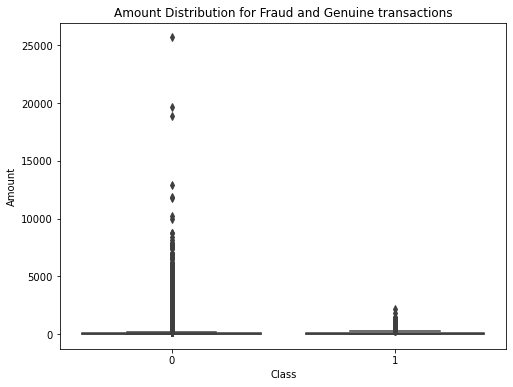

In [11]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Class', y='Amount',data = my_data)
plt.title('Amount Distribution for Fraud and Genuine transactions')
plt.show()

 outliers should not be the fraudulent transaction.

/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


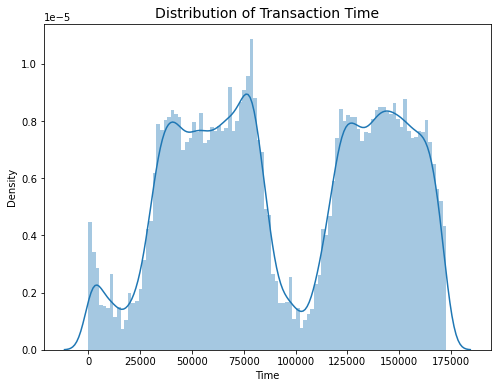

In [12]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Transaction Time', fontsize=14)
sns.distplot(my_data['Time'], bins=100)
plt.show()

2 peaks: 高峰在白天，中间的大低谷是两天交界处的黑夜（因为统计数据只包含两天）

/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


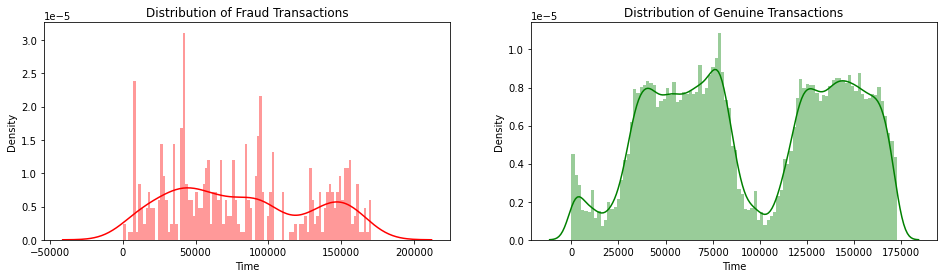

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))

sns.distplot(my_data[(my_data['Class'] == 1)]['Time'], bins=100, color='red', ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(my_data[(my_data['Class'] == 0)]['Time'], bins=100, color='green', ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

plt.show()

fraud transaction就没有高低谷之分，反而黑夜是诈骗交易的高发时间

In [14]:
#top 10 features which are highly correlated with a price
my_data[['Amount', 'Time','Class']].corr()['Class'].sort_values(
    ascending=False).head(10)

Class     1.000000
Amount    0.005632
Time     -0.012323
Name: Class, dtype: float64

<AxesSubplot:title={'center':'Pearson Correlation Matrix'}>

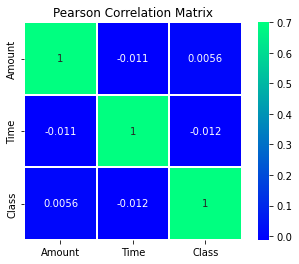

In [15]:
plt.title('Pearson Correlation Matrix')
sns.heatmap(my_data[['Amount', 'Time','Class']].corr(),
            linewidths=0.25,vmax=0.7,square=True,cmap="winter",
            linecolor='w',annot=True)


no features are highly correlated with any other features

## scale the data: Amount & Time 归一化

It is a good idea to scale the data so that the column(feature) with lesser significance might not end up dominating the objective function due to its larger range. 

In addition, features having different unit should also be scaled thus providing each feature equal initial weightage.

In [16]:
# Scale by Log
my_data['Amount_log'] = np.log(my_data.Amount + 0.0001)
my_data['Time_log'] = np.log(my_data.Time + 0.0001)

In [17]:
# Scale by Standardization
my_data["norm_Amount"]=StandardScaler().fit_transform(
    my_data["Amount"].values.reshape(-1,1))
my_data["norm_Time"]=StandardScaler().fit_transform(
    my_data["Time"].values.reshape(-1,1))

Text(0.5, 1.0, 'Class vs Scaled Amount')

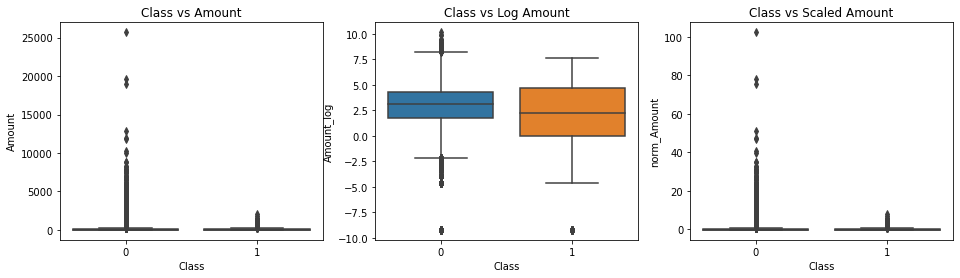

In [18]:
# 比较两种transformation好坏
fig , axs = plt.subplots(nrows = 1 , ncols = 3, figsize = (16,4))

sns.boxplot(x ="Class",y="Amount",data=my_data, ax = axs[0])
axs[0].set_title("Class vs Amount")

sns.boxplot(x ="Class",y="Amount_log",data=my_data, ax = axs[1])
axs[1].set_title("Class vs Log Amount")

sns.boxplot(x ="Class",y="norm_Amount",data=my_data, ax = axs[2])
axs[2].set_title("Class vs Scaled Amount")

Text(0.5, 1.0, 'Class vs Scaled Time')

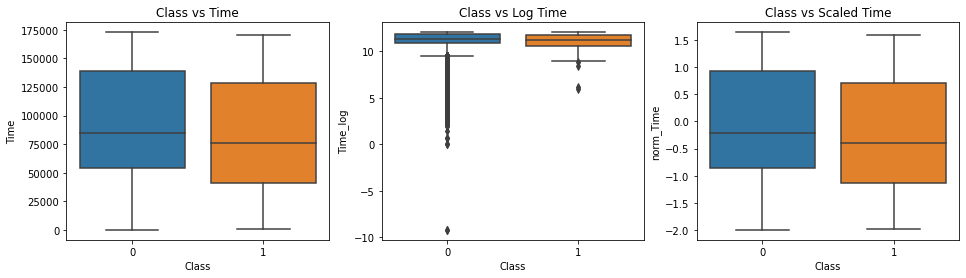

In [19]:
fig , axs = plt.subplots(nrows = 1 , ncols = 3, figsize = (16,4))

sns.boxplot(x ="Class",y="Time",data=my_data, ax = axs[0])
axs[0].set_title("Class vs Time")

sns.boxplot(x ="Class",y="Time_log",data=my_data, ax = axs[1])
axs[1].set_title("Class vs Log Time")

sns.boxplot(x ="Class",y="norm_Time",data=my_data, ax = axs[2])
axs[2].set_title("Class vs Scaled Time")

对Amount来说，scaling the amount by log will best suit for our model 因为它让outlier不那么明显；对Time来说，scaling by standardization is better.

## Saving preprossed data as serialized files

In [20]:
my_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Amount_log', 'Time_log', 'norm_Amount', 'norm_Time'],
      dtype='object')

In [21]:
X = my_data.drop(["Time","Amount",'Time_log', 'norm_Amount', 
                  'norm_Time',"Class"],axis=1)
y = my_data['Class']

In [22]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_log
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008099
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989578
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936639
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816242
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.261235
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,3.210444
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,4.217743
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,2.302595


In [23]:
my_data.columns
dep_vars = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',  "Time",'Amount_log']
indep_vars = ["Class"]


In [24]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np
mi = {}
for var in dep_vars:
    dep_var = np.array(my_data[[var]])
    indep_var = np.array(my_data[["Class"]])
    m_info = mutual_info_regression(dep_var, indep_var)
    #print(m_info)
    mi[var] = m_info
mi

/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jiaqixia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

{'V1': array([0.00211251]),
 'V2': array([0.00336584]),
 'V3': array([0.0051414]),
 'V4': array([0.005111]),
 'V5': array([0.00240669]),
 'V6': array([0.00256076]),
 'V7': array([0.00387606]),
 'V8': array([0.00175576]),
 'V9': array([0.00408764]),
 'V10': array([0.0074762]),
 'V11': array([0.0070179]),
 'V12': array([0.00745015]),
 'V13': array([0.00022265]),
 'V14': array([0.00823394]),
 'V15': array([0.00039672]),
 'V16': array([0.00610912]),
 'V17': array([0.00832475]),
 'V18': array([0.00427677]),
 'V19': array([0.00163742]),
 'V20': array([0.00150916]),
 'V21': array([0.00251182]),
 'V22': array([0.00045425]),
 'V23': array([0.00079133]),
 'V24': array([0.00065397]),
 'V25': array([0.00048076]),
 'V26': array([0.00030214]),
 'V27': array([0.00250088]),
 'V28': array([0.00189682]),
 'Time': array([0.00172739]),
 'Amount_log': array([0.00198654])}

In [25]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    shuffle=True, 
                                                    random_state=101)


In [26]:
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (199364, 29)
y_train -  (199364,)
X_test -  (85443, 29)
y_test -  (85443,)


# 逻辑回归

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.87      0.61      0.72       144

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [28]:
print('Accuracy:{0:0.5f}'.format(metrics.accuracy_score(y_pred,
                                                         y_test)))
print('AUC:{0:0.5f}'.format(metrics.roc_auc_score(y_test,
                                                    y_pred)))
print('Precision:{0:0.5f}'.format(metrics.precision_score(y_test,
                                                          y_pred)))
print('Recall:{0:0.5f}'.format(metrics.recall_score(y_test,
                                                      y_pred)))
print('F1:{0:0.5f}'.format(metrics.f1_score(y_test,y_pred)))


Accuracy:0.99919
AUC:0.80548
Precision:0.87129
Recall:0.61111
F1:0.71837


-Recall (True Positive Rate): % of all fraudulent transactions cases captured. 

-Precision: Out of all items labeled as fraud, what percentage of them is actually fraud? 

-Accuracy: How correct the model is (misleading for fraud/imbalanced data) 

-F1 score: combination of recall and precision into one metric. F1 score is the weighted average of precision and recall, taking BOTH false positives and false negatives into account. Usually much more useful than accuracy, especially with uneven classes. 值越大意味着模型越好

In [29]:
# real accuracy
print(pd.Series(y_test).value_counts())
print()
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
print(cnf_matrix)

0    85299
1      144
Name: Class, dtype: int64

[[85286    13]
 [   56    88]]


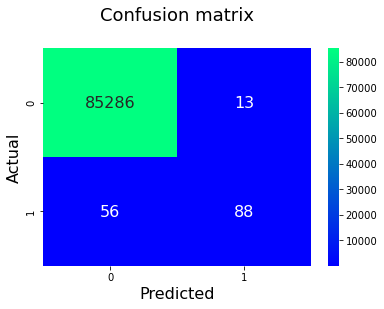

In [30]:
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True
                , annot_kws={"size":16},cmap="winter" ,fmt='g')
plt.title('Confusion matrix', y=1.1, fontsize = 18)
plt.ylabel('Actual',fontsize = 16)
plt.xlabel('Predicted',fontsize = 16)
plt.show()
# True Positive: 78

Recall score and F1 score to measure the performance of our model, not the accuracy.

In [31]:
metrics.roc_auc_score(y_test , y_pred) 

0.805479353020942

AUC -  0.805479353020942 



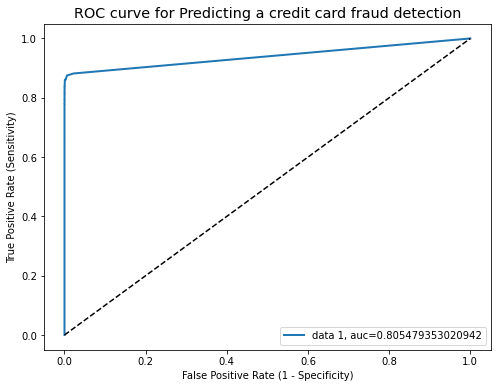

In [33]:
# ROC 曲线
rf= RandomForestClassifier()
rf.fit(X_train, y_train)
probas_pred = rf.predict_proba(X_test)
plt.figure(figsize=(8,6))

fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_pred[:,1:2])

auc = metrics.roc_auc_score(y_test, y_pred)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

f1=0.718


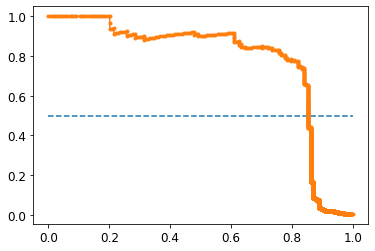

In [34]:
# calculate precision-recall 曲线
probas_pred = logreg.predict_proba(X_test)
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probas_pred[:,1:2])

# calculate F1 score
f1 = metrics.f1_score(y_test, y_pred)

print('f1=%.3f' % (f1))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the roc curve for the model
plt.plot(recall, precision, marker='.')

# show the plot
plt.show()

## 对不平衡数据的处理

### 随机过采样 & 随机欠采样

#### 逻辑回归 with Random Undersampling technique

In [35]:
# 逻辑回归 with Random Undersampling technique
from collections import Counter 
from sklearn.datasets import make_classification
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_rus))

Original dataset shape Counter({0: 199016, 1: 348})
Resampled dataset shape Counter({0: 348, 1: 348})


In [36]:
logreg = LogisticRegression()
logreg.fit(X_train_rus, y_train_rus)
y_pred_rus = logreg.predict(X_test)

In [37]:
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred_rus,
                                                         y_test)))
print('AUC:{0:0.5f}'.format(metrics.roc_auc_score(y_test,
                                                  y_pred_rus)))
print('Precision:{0:0.5f}'.format(metrics.precision_score(y_test
                                                          ,y_pred_rus)))
print('Recall:{0:0.5f}'.format(metrics.recall_score(y_test,
                                                    y_pred_rus)))
print('F1:{0:0.5f}'.format(metrics.f1_score(y_test
                                            ,y_pred_rus)))


Accuracy :0.97406
AUC:0.94195
Precision:0.05613
Recall:0.90972
F1:0.10573


AUC -  0.9419477123608327 



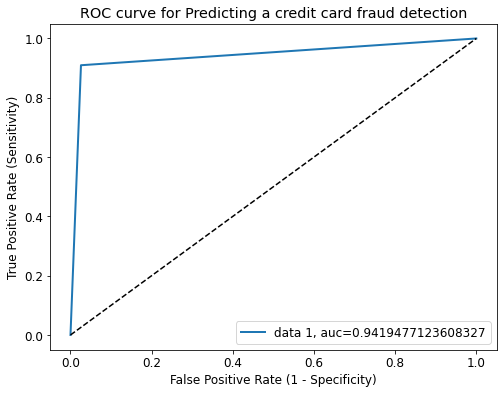

In [38]:
# plot ROC Curve
plt.figure(figsize=(8,6))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rus)

auc = metrics.roc_auc_score(y_test, y_pred_rus)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

f1=0.106


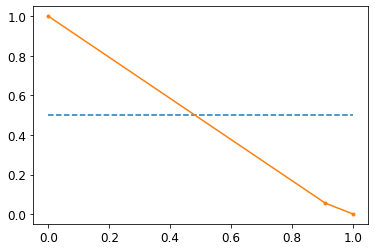

In [39]:
# calculate precision-recall curve
precision,recall,thresholds = metrics.precision_recall_curve(y_test,
                                                               y_pred_rus)

# calculate F1 score
f1 = metrics.f1_score(y_test, y_pred_rus)
print('f1=%.3f' % (f1))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()


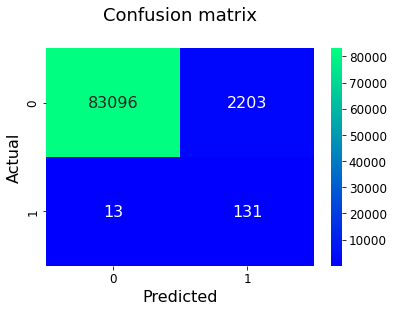

In [40]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test , y_pred_rus)
sns.heatmap(pd.DataFrame(cnf_matrix),annot=True, 
            annot_kws={"size": 16}, cmap="winter" ,fmt='g')

plt.title('Confusion matrix', y=1.1, fontsize = 18)
plt.xlabel('Predicted',fontsize = 16)
plt.ylabel('Actual',fontsize = 16)
plt.show()

#### 逻辑回归 with Random Oversampling technique

In [41]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_ros))

Original dataset shape Counter({0: 199016, 1: 348})
Resampled dataset shape Counter({0: 199016, 1: 199016})


In [42]:
# Oversampling with Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_ros, y_train_ros)

y_pred_ros = logreg.predict(X_test)

In [43]:
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred_ros,
                                                         y_test)))
print('AUC:{0:0.5f}'.format(metrics.roc_auc_score(y_test,
                                                  y_pred_ros)))
print('Precision:{0:0.5f}'.format(metrics.precision_score(y_test
                                                          ,y_pred_ros)))
print('Recall:{0:0.5f}'.format(metrics.recall_score(y_test,
                                                    y_pred_ros)))
print('F1:{0:0.5f}'.format(metrics.f1_score(y_test
                                            ,y_pred_ros)))


Accuracy :0.97802
AUC:0.93700
Precision:0.06476
Recall:0.89583
F1:0.12079


AUC -  0.9369962572832038 



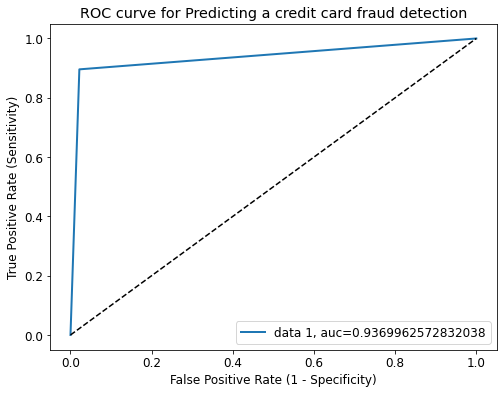

In [44]:
# plot ROC Curve

plt.figure(figsize=(8,6))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_ros)

auc = metrics.roc_auc_score(y_test, y_pred_ros)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

f1=0.121


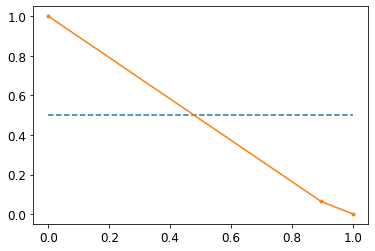

In [45]:
# precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_ros)

# calculate F1 score
f1 = metrics.f1_score(y_test, y_pred_ros)
print('f1=%.3f' % (f1))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the roc curve for the model
plt.plot(recall, precision, marker='.')

plt.show()


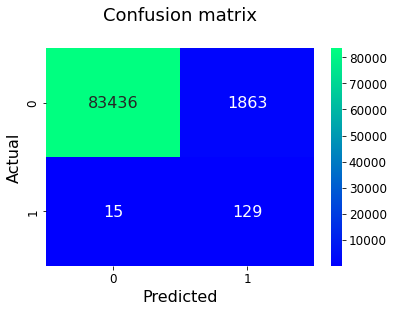

In [46]:
# Confusion Matrix

cnf_matrix = metrics.confusion_matrix(y_test , y_pred_ros)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, 
            annot_kws={"size": 16}, cmap="winter" ,fmt='g')

plt.title('Confusion matrix', y=1.1, fontsize = 18)
plt.xlabel('Predicted',fontsize = 16)
plt.ylabel('Actual',fontsize = 16)
plt.show()

### SMOTE 过采样

In [47]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_smote))

Original dataset shape Counter({0: 199016, 1: 348})
Resampled dataset shape Counter({0: 199016, 1: 199016})


In [48]:
# SMOTE Sampling with Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

y_pred_smote = logreg.predict(X_test)

In [49]:
print('Accuracy:{0:0.5f}'.format(metrics.accuracy_score(y_test , y_pred_smote))) 
print('AUC:{0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred_smote)))
print('Precision:{0:0.5f}'.format(metrics.precision_score(y_test , y_pred_smote)))
print('Recall:{0:0.5f}'.format(metrics.recall_score(y_test , y_pred_smote)))
print('F1:{0:0.5f}'.format(metrics.f1_score(y_test , y_pred_smote)))


Accuracy:0.97602
AUC:0.93599
Precision:0.05964
Recall:0.89583
F1:0.11183


AUC -  0.9359939008663642 



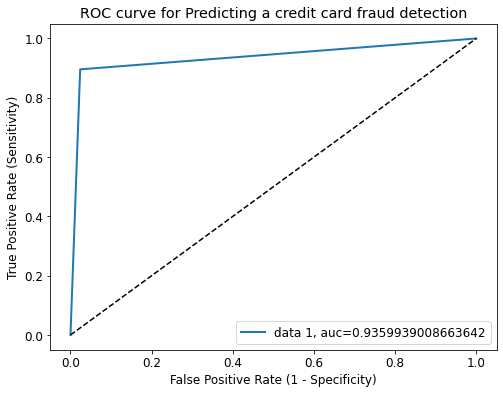

In [50]:
# plot ROC Curve

plt.figure(figsize=(8,6))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_smote)

auc = metrics.roc_auc_score(y_test, y_pred_smote)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

f1=0.112


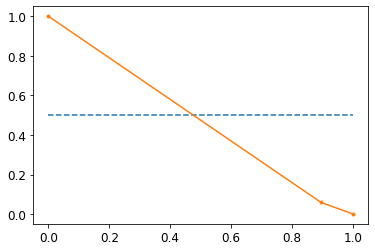

In [51]:
# calculate precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_smote)

# calculate F1 score
f1 = metrics.f1_score(y_test, y_pred_smote)
print('f1=%.3f' % (f1))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()

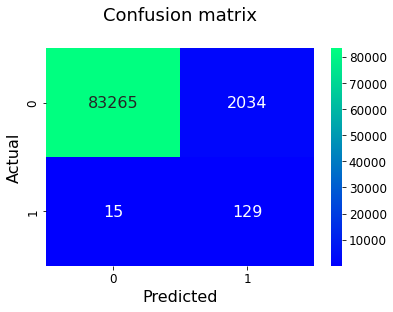

In [52]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test , y_pred_smote)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, 
            annot_kws={"size": 16}, cmap="winter" ,fmt='g')

plt.title('Confusion matrix', y=1.1, fontsize = 18)
plt.xlabel('Predicted',fontsize = 16)
plt.ylabel('Actual',fontsize = 16)
plt.show()

### ADASYN 自适应合成采样

In [53]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train,
                                                     y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_adasyn))

Original dataset shape Counter({0: 199016, 1: 348})
Resampled dataset shape Counter({0: 199016, 1: 199012})


In [54]:
#  ADASYN Sampling with Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = logreg.predict(X_test)

In [55]:
print('Accuracy:{0:0.5f}'.format(metrics.accuracy_score(y_pred , y_pred_adasyn))) 
print('AUC:{0:0.5f}'.format(metrics.roc_auc_score(y_test , y_pred_adasyn)))
print('Precision:{0:0.5f}'.format(metrics.precision_score(y_test , y_pred_adasyn)))
print('Recall:{0:0.5f}'.format(metrics.recall_score(y_test , y_pred_adasyn)))
print('F1:{0:0.5f}'.format(metrics.f1_score(y_test , y_pred_adasyn)))


Accuracy:0.91831
AUC:0.93151
Precision:0.01921
Recall:0.94444
F1:0.03765


AUC -  0.9315124835382986 



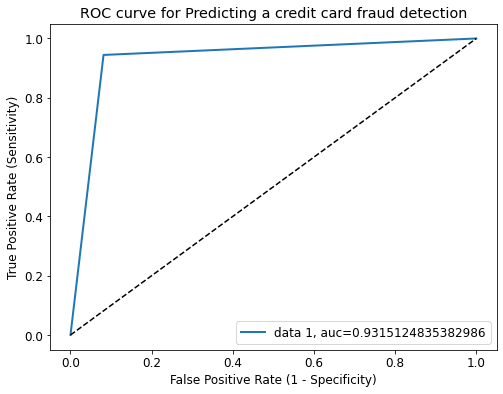

In [56]:
# plot ROC Curve

plt.figure(figsize=(8,6))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_adasyn)

auc = metrics.roc_auc_score(y_test, y_pred_adasyn)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a credit card fraud detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()


f1=0.038


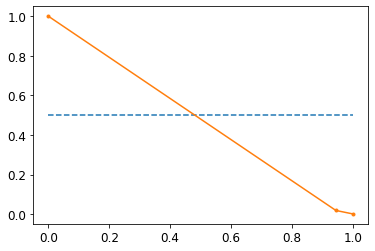

In [57]:
# calculate precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_adasyn)

# calculate F1 score
f1 = metrics.f1_score(y_test, y_pred_adasyn)
print('f1=%.3f' % (f1))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()


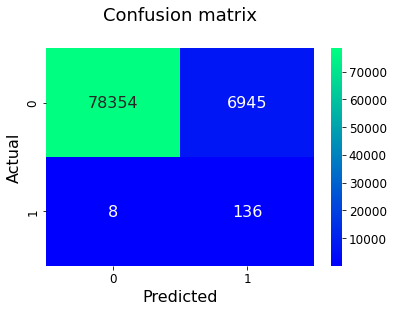

In [58]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test , y_pred_adasyn)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, 
            annot_kws={"size": 16}, cmap="winter" ,fmt='g')

plt.title('Confusion matrix', y=1.1, fontsize = 18)
plt.xlabel('Predicted',fontsize = 16)
plt.ylabel('Actual',fontsize = 16)
plt.show()

不均衡数据集：Recall score=62.4%；

highly biased towards genuine transactions and creates a model which is not able to predict the fraudulent transactions correctly.

均衡数据集：Recall score $\approx$ 90%

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [60]:
names_lst = []

# Empty list to capture performance matrix for train set
aucs_train_lst = []
accuracy_train_lst = []
precision_train_lst = []
recall_train_lst = []
f1_train_lst = []

# Empty list to capture performance matrix for test set
aucs_test_lst = []
accuracy_test_lst = []
precision_test_lst = []
recall_test_lst = []
f1_test_lst = []

# Function for model building and performance measure
import time
Time = []

def build_measure_model(models):
    plt.figure(figsize=(12,6))
    t0=time.time()
    for name, model, X_train, y_train, X_test, y_test in models:
        
        names_lst.append(name)

        # Build model
        model.fit(X_train, y_train)
        
        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        t1=time.time()
        Time.append((t1-t0))
        
        # calculate accuracy
        Accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
        accuracy_train_lst.append(Accuracy_train)
        
        Accuracy_test = metrics.accuracy_score(y_test, y_test_pred)
        accuracy_test_lst.append(Accuracy_test)

        # calculate auc
        Aucs_train = metrics.roc_auc_score(y_train, y_train_pred)
        aucs_train_lst.append(Aucs_train)
        
        Aucs_test = metrics.roc_auc_score(y_test , y_test_pred)
        aucs_test_lst.append(Aucs_test)

        # calculate precision
        PrecisionScore_train = metrics.precision_score(y_train , y_train_pred)
        precision_train_lst.append(PrecisionScore_train)
        
        PrecisionScore_test = metrics.precision_score(y_test , y_test_pred)
        precision_test_lst.append(PrecisionScore_test)

        # calculate recall
        RecallScore_train = metrics.recall_score(y_train , y_train_pred)
        recall_train_lst.append(RecallScore_train)
        
        RecallScore_test = metrics.recall_score(y_test , y_test_pred)
        recall_test_lst.append(RecallScore_test)

        # calculate f1 score
        F1Score_train = metrics.f1_score(y_train , y_train_pred)
        f1_train_lst.append(F1Score_train)
        
        F1Score_test = metrics.f1_score(y_test , y_test_pred)
        f1_test_lst.append(F1Score_test)

        #print('F1 Score of '+ name +' model : {0:0.5f}'.format(F1Score_test))

        # draw confusion matrix
        cnf_matrix = metrics.confusion_matrix(y_test , y_test_pred)

        print("Model Name :", name)
        
        print('Train Accuracy :{0:0.5f}'.format(Accuracy_train)) 
        print('Test Accuracy :{0:0.5f}'.format(Accuracy_test))
        
        print('Train AUC : {0:0.5f}'.format(Aucs_train))
        print('Test AUC : {0:0.5f}'.format(Aucs_test))
        
        print('Train Precision : {0:0.5f}'.format(PrecisionScore_train))
        print('Test Precision : {0:0.5f}'.format(PrecisionScore_test))
        
        print('Train Recall : {0:0.5f}'.format(RecallScore_train))
        print('Test Recall : {0:0.5f}'.format(RecallScore_test))
        
        print('Train F1 : {0:0.5f}'.format(F1Score_train))
        print('Test F1 : {0:0.5f}'.format(F1Score_test))
        
        print('Confusion Matrix : \n', cnf_matrix)
        print("\n")


        # plot ROC Curve
        probas_pred = model.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_pred[:,1:2])
        #fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
        auc = metrics.roc_auc_score(y_test, y_test_pred)
        plt.plot(fpr,tpr,linewidth=2, label=name + ", auc="+str(auc))
        
    plt.legend(loc=4)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for Predicting a credit card fraud detection')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    #plt.tight_layout()
    #fig.savefig("models.png")
    plt.show()


# 逻辑回归 (LR)

Model Name : LR imbalance
Train Accuracy :0.99916
Test Accuracy :0.99920
Train AUC : 0.80452
Test AUC : 0.80549
Train Precision : 0.87243
Test Precision : 0.88000
Train Recall : 0.60920
Test Recall : 0.61111
Train F1 : 0.71743
Test F1 : 0.72131
Confusion Matrix : 
 [[85287    12]
 [   56    88]]


Model Name : LR Undersampling
Train Accuracy :0.94971
Test Accuracy :0.97252
Train AUC : 0.94971
Test AUC : 0.94117
Train Precision : 0.97568
Test Precision : 0.05312
Train Recall : 0.92241
Test Recall : 0.90972
Train F1 : 0.94830
Test F1 : 0.10038
Confusion Matrix : 
 [[82964  2335]
 [   13   131]]


Model Name : LR Oversampling
Train Accuracy :0.95325
Test Accuracy :0.97799
Train AUC : 0.95325
Test AUC : 0.93698
Train Precision : 0.97630
Test Precision : 0.06466
Train Recall : 0.92906
Test Recall : 0.89583
Train F1 : 0.95209
Test F1 : 0.12062
Confusion Matrix : 
 [[83433  1866]
 [   15   129]]


Model Name : LR SMOTE
Train Accuracy :0.94666
Test Accuracy :0.97604
Train AUC : 0.94666
Test AU

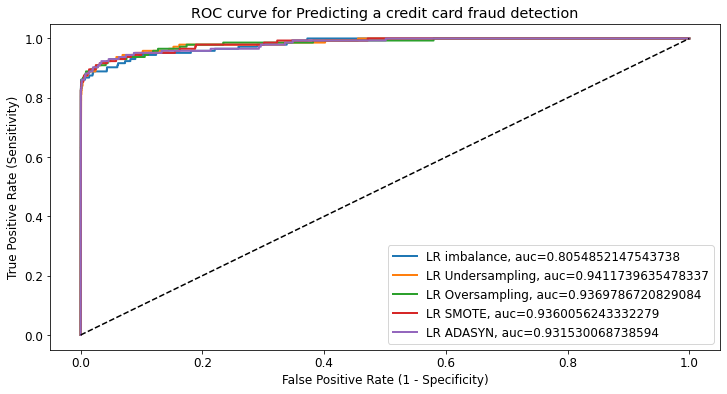

In [61]:
LRmodels = []
LRmodels.append(('LR imbalance', LogisticRegression(solver='liblinear', multi_class='ovr'), X_train,y_train,X_test,y_test))

LRmodels.append(('LR Undersampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_rus,y_train_rus,X_test,y_test))

LRmodels.append(('LR Oversampling', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_ros,y_train_ros,X_test,y_test))

LRmodels.append(('LR SMOTE', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_smote,y_train_smote,X_test,y_test))

LRmodels.append(('LR ADASYN', LogisticRegression(solver='liblinear', multi_class='ovr'),X_train_adasyn,y_train_adasyn,X_test,y_test))

# Call function to create model and measure its performance
build_measure_model(LRmodels)

In [62]:
Time

[0.7770800590515137,
 0.9722957611083984,
 2.2731688022613525,
 3.728368043899536,
 5.691169023513794]

# 随机森林


Model Name : RF imbalance
Train Accuracy :1.00000
Test Accuracy :0.99959
Train AUC : 1.00000
Test AUC : 0.89927
Train Precision : 1.00000
Test Precision : 0.95041
Train Recall : 1.00000
Test Recall : 0.79861
Train F1 : 1.00000
Test F1 : 0.86792
Confusion Matrix : 
 [[85293     6]
 [   29   115]]


Model Name : RF Undersampling
Train Accuracy :1.00000
Test Accuracy :0.96530
Train AUC : 1.00000
Test AUC : 0.93062
Train Precision : 1.00000
Test Precision : 0.04190
Train Recall : 1.00000
Test Recall : 0.89583
Train F1 : 1.00000
Test F1 : 0.08005
Confusion Matrix : 
 [[82349  2950]
 [   15   129]]


Model Name : RF Oversampling
Train Accuracy :1.00000
Test Accuracy :0.99959
Train AUC : 1.00000
Test AUC : 0.89927
Train Precision : 1.00000
Test Precision : 0.95041
Train Recall : 1.00000
Test Recall : 0.79861
Train F1 : 1.00000
Test F1 : 0.86792
Confusion Matrix : 
 [[85293     6]
 [   29   115]]


Model Name : RF SMOTE
Train Accuracy :1.00000
Test Accuracy :0.99952
Train AUC : 1.00000
Test AU

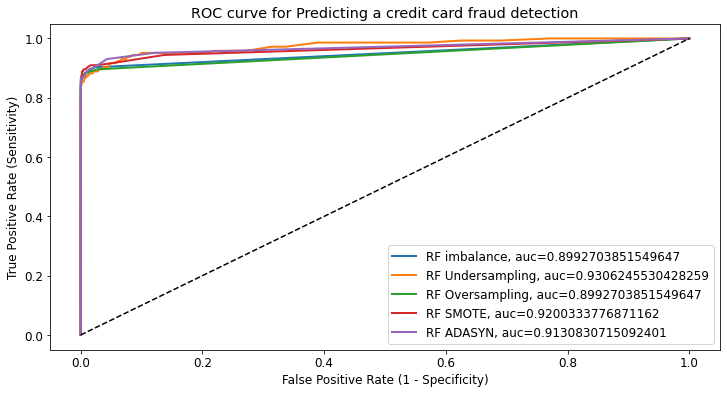

In [63]:
#-----------------Random Forest (RF) ------------------#
RFmodels = []

RFmodels.append(('RF imbalance', RandomForestClassifier(),X_train,y_train,X_test,y_test))

RFmodels.append(('RF Undersampling', RandomForestClassifier(),X_train_rus,y_train_rus,X_test,y_test))

RFmodels.append(('RF Oversampling', RandomForestClassifier(),X_train_ros,y_train_ros,X_test,y_test))

RFmodels.append(('RF SMOTE', RandomForestClassifier(),X_train_smote,y_train_smote,X_test,y_test))

RFmodels.append(('RF ADASYN', RandomForestClassifier(),X_train_adasyn,y_train_adasyn,X_test,y_test))

# Call function to create model and measure its performance
build_measure_model(RFmodels)

In [64]:
Time

[0.7770800590515137,
 0.9722957611083984,
 2.2731688022613525,
 3.728368043899536,
 5.691169023513794,
 106.49927926063538,
 107.65646123886108,
 190.6289999485016,
 373.89689207077026,
 575.848669052124]

# KNN

In [65]:
#------------------ K-Nearest Neighbors (KNN) ------------------#
#KNNmodels = []

#KNNmodels.append(('KNN imbalance', KNeighborsClassifier(),X_train,y_train,X_test,y_test))
#KNNmodels.append(('KNN Undersampling', KNeighborsClassifier(),X_train_rus,y_train_rus,X_test,y_test))
#KNNmodels.append(('KNN Oversampling', KNeighborsClassifier(),X_train_ros,y_train_ros,X_test,y_test))
#KNNmodels.append(('KNN SMOTE', KNeighborsClassifier(),X_train_smote,y_train_smote,X_test,y_test))
#KNNmodels.append(('KNN ADASYN', KNeighborsClassifier(),X_train_adasyn,y_train_adasyn,X_test,y_test))

# Call function to create model and measure its performance
#build_measure_model(KNNmodels)


# SVM

In [66]:
#------------------ Support Vector Machines (SVM) ------------------#
#SVMmodels = []

#SVMmodels.append(('SVM imbalance', SVC(gamma='auto'),X_train,y_train,X_test,y_test))
#SVMmodels.append(('SVM Undersampling', SVC(gamma='auto'),X_train_rus,y_train_rus,X_test,y_test))
#SVMmodels.append(('SVM Oversampling', SVC(gamma='auto'),X_train_ros,y_train_ros,X_test,y_test))
#SVMmodels.append(('SVM SMOTE', SVC(gamma='auto'),X_train_smote,y_train_smote,X_test,y_test))
#SVMmodels.append(('SVM ADASYN', SVC(gamma='auto'),X_train_adasyn,y_train_adasyn,X_test,y_test))

# Call function to create model and measure its performance
#build_measure_model(SVMmodels)


# 朴素贝叶斯（NB）

In [67]:
#------------------ Gaussian Naive Bayes (NB) ------------------#
#NBmodels = []

#NBmodels.append(('NB imbalance', GaussianNB(),X_train,y_train,X_test,y_test))
#NBmodels.append(('NB Undersampling', GaussianNB(),X_train_rus,y_train_rus,X_test,y_test))
#NBmodels.append(('NB Oversampling', GaussianNB(),X_train_ros,y_train_ros,X_test,y_test))
#NBmodels.append(('NB SMOTE', GaussianNB(),X_train_smote,y_train_smote,X_test,y_test))
#NBmodels.append(('NB ADASYN', GaussianNB(),X_train_adasyn,y_train_adasyn,X_test,y_test))

# Call function to create model and measure its performance
#build_measure_model(NBmodels)


In [68]:
data = {'Model':names_lst,
       #'Accuracy_Train':accuracy_train_lst,
       'Accuracy_Test':accuracy_test_lst,
       #'AUC_Train':aucs_train_lst,
       'AUC_Test':aucs_test_lst,
       #'PrecisionScore_Train':precision_train_lst,
       'PrecisionScore_Test':precision_test_lst,
       #'RecallScore_Train':recall_train_lst,
       'RecallScore_Test':recall_test_lst,
       #'F1Score_Train':f1_train_lst,
       'F1Score_Test':f1_test_lst}

print("Performance measures of various classifiers: \n")
performance_df = pd.DataFrame(data) 
performance_df.sort_values(['F1Score_Test','RecallScore_Test',
                            'AUC_Test'],ascending=False)


Performance measures of various classifiers: 



,Model,Accuracy_Test,AUC_Test,PrecisionScore_Test,RecallScore_Test,F1Score_Test
5,RF imbalance,0.999590,0.899270,0.950413,0.798611,0.867925
7,RF Oversampling,0.999590,0.899270,0.950413,0.798611,0.867925
8,RF SMOTE,0.999520,0.920033,0.870504,0.840278,0.855124
9,RF ADASYN,0.999485,0.913083,0.862319,0.826389,0.843972
0,LR imbalance,0.999204,0.805485,0.880000,0.611111,0.721311
2,LR Oversampling,0.977985,0.936979,0.064662,0.895833,0.120617
3,LR SMOTE,0.976043,0.936006,0.059695,0.895833,0.111931
1,LR Undersampling,0.972520,0.941174,0.053122,0.909722,0.100383
6,RF Undersampling,0.965299,0.930625,0.041897,0.895833,0.080050
4,LR ADASYN,0.918659,0.931530,0.019214,0.944444,0.037663


All of the scores for Random Forest with Oversampling technique and the Random Forest with SMOTE technique models are very promising for our dataset!

In the ROC graph above, the AUC scores for Random Forest with Oversampling technique is pretty high,
which is what we’d like to see. As we move further right along the curve, we both capture more True Positives but also incur more False Positives. This means we capture more fraudulent transactions, but also flag even more normal transactions as fraudulent.



###  Random Forest with Oversampling technique is our final model, as this gives highest F1 score of 86.89% on test datasets.

# 网格化搜索确定最优参数

## Grid Search with 逻辑回归

In [69]:
from sklearn.model_selection import GridSearchCV
#------------ Logistic Regression ------------#
log_reg_params = {"solver": ['saga'],
                  "penalty": ['l1', 'l2'], 
                  'C':  [0.01, 0.1, 1, 10, 100], 
                  "max_iter" : [100000]},

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train_rus,y_train_rus)

# Logistic Regression best estimator
print("Logistic Regression best estimator : \n",grid_log_reg.best_estimator_)

# predict test dataset
y_pred_lr = grid_log_reg.predict(X_test)

# f1 score
print('\nLogistic Regression f1 Score : {0:0.5f}'.format(metrics.f1_score(y_test , y_pred_lr)))

KeyboardInterrupt: 